In [22]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt

from collections import defaultdict
import nltk
from nltk import word_tokenize
from nltk.corpus import brown
from nltk import wordpunct_tokenize # tokenize for non-English languages
import stanza

nltk.download('brown')
fd = nltk.FreqDist(brown.words())

[nltk_data] Downloading package brown to /home/haoquanz/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
def fetch_text(dataset):
    human_text = dataset['text'][dataset.label == 0].tolist()
    machine_text = dataset['text'][dataset.label == 1].tolist()
    return human_text, machine_text

In [7]:
train_df = pd.read_csv('train_wiki.csv')
test_df = pd.read_csv('test_wiki.csv')
dataset_name = 'GPT-wiki'

### Answer Length

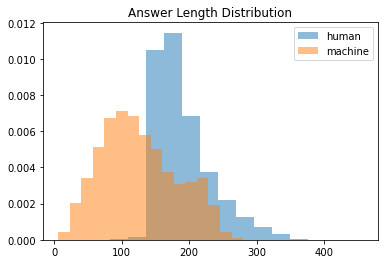

In [8]:
def text_length(all_text):
    list_of_words = [[word for word in wordpunct_tokenize(text) if word.isalpha()] for text in all_text]
    list_of_len = [len(words) for words in list_of_words]
    return list_of_len

human_text, machine_text = fetch_text(train_df)

human_len = text_length(human_text)
machine_len = text_length(machine_text)


plt.hist(human_len, bins=16, alpha=0.5, label='human', density=True)
plt.hist(machine_len, bins=16, alpha=0.5, label='machine', density=True)
# plt.xscale('log')
plt.legend(loc='upper right')
plt.title("Answer Length Distribution")
plt.savefig(f'{dataset_name}_length.png')

### Frequent Words

In [13]:
def freq_func(text, fd):
    all_text = ' '.join(text)
    words = wordpunct_tokenize(all_text)
    words = [word.lower() for word in words if word.isalpha()]
    freq = [fd[word] for word in words]
    words_len = np.mean([len(word) for word in words])
    rare_words = [word for word in words if fd[word] < 100]
    print(len(rare_words), rare_words[0:10]) # avoid printing too much rare words
    norm_freq = np.array(freq)
    return norm_freq, words_len


In [14]:
human_text, machine_text = fetch_text(train_df)

human_freq, human_words_len = freq_func(human_text, fd)
machine_freq, machine_words_len = freq_func(machine_text, fd)

10018932 ['raúl', 'velasco', 'ramírez', 'april', 'november', 'mexican', 'host', 'producer', 'tv', 'siempre']
6237608 ['mira', 'bartók', 'née', 'herr', 'hungarian', 'composer', 'twelve', 'operas', 'fourteen', 'symphonies']


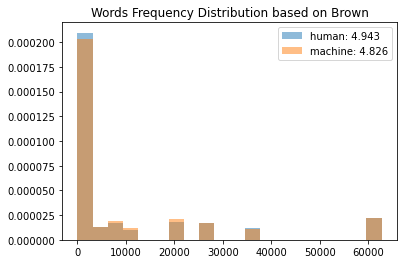

In [15]:
plt.hist(human_freq, bins=20, alpha=0.5, label=f'human: {human_words_len:.3f}', density=True)
plt.hist(machine_freq, bins=20, alpha=0.5, label=f'machine: {machine_words_len:.3f}', density=True)
# plt.xscale('log')
plt.legend(loc='upper right')
plt.title("Words Frequency Distribution based on Brown")
plt.savefig(f'{dataset_name}_freq.png')

### POS tagging

In [16]:
def dict_add(list_of_dicts):
    items = set().union(*list_of_dicts)
    res = {}
    for item in items:
        res[item] = sum(d.get(item, 0) for d in list_of_dicts) / len(list_of_dicts)
    return res

In [17]:
def pos_func(text, nlp):
    pos_dict = defaultdict(int)
    for sent in text:
        doc = nlp(sent)
        for sent in doc.sentences:
            for word in sent.words:
                pos_dict[word.xpos] += 1
    return pos_dict

def norm_func(human_dist, machine_dist):
    all_keys = sorted(set().union(human_dist.keys(), machine_dist.keys()))
    human_dist_norm = {k: human_dist.get(k, 0)  / sum(human_dist.values()) for k in all_keys}
    machine_dist_norm = {k: machine_dist.get(k, 0) / sum(machine_dist.values()) for k in all_keys}
    return human_dist_norm, machine_dist_norm

def pipe_add(func, all_text, nlp):
    dict_func =  [func(text, nlp) for text in tqdm(all_text)]
    dict_all = dict_add(dict_func)
    return dict_all

def draw_func(human_dist_norm, machine_dist_norm, dataset_name, func_name):
    plt.style.use('default')
    plt.bar(x=list(human_dist_norm.keys()), height=list(human_dist_norm.values()), alpha=0.5, label='human')
    plt.bar(x=list(machine_dist_norm.keys()), height=list(machine_dist_norm.values()), alpha=0.5, label='machine')

    # rotate the x-axis labels
    plt.xticks(rotation=90)
    plt.legend()
    if func_name == "deprel":
        plt.title(f'Dependency Relation Distribution on {dataset_name}')
    elif func_name == "xpos":
        plt.title(f'POS Tagging Distribution on {dataset_name}')
    plt.savefig(f'{func_name}_dist_{dataset_name}.png', dpi=300)
    plt.show()

In [18]:
train_df.to_csv(f'{dataset_name}_train.csv', index=False)

2023-04-18 19:53:32 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-04-18 19:53:33 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-04-18 19:53:33 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2023-04-18 19:53:33 INFO: Using device: cuda
2023-04-18 19:53:33 INFO: Loading: tokenize
2023-04-18 19:53:33 INFO: Loading: pos
2023-04-18 19:53:33 INFO: Done loading processors!


  0%|          | 0/160 [00:00<?, ?it/s]

  1%|          | 1/160 [00:17<47:11, 17.81s/it]

  1%|▏         | 2/160 [00:35<46:48, 17.78s/it]

  2%|▏         | 3/160 [00:58<52:33, 20.09s/it]

  2%|▎         | 4/160 [01:20<54:04, 20.80s/it]

  3%|▎         | 5/160 [01:38<50:58, 19.73s/it]

  4%|▍         | 6/160 [02:11<1:02:36, 24.39s/it]

  4%|▍         | 7/160 [02:32<59:11, 23.21s/it]  

  5%|▌         | 8/160 [02:46<51:31, 20.34s/it]

  6%|▌         | 9/160 [03:21<1:02:25, 24.81s/it]

  6%|▋         | 10/160 [03:50<1:05:48, 26.33s/it]

  7%|▋   

 85%|████████▌ | 136/160 [45:01<07:21, 18.39s/it]

 86%|████████▌ | 137/160 [45:28<07:58, 20.82s/it]

 86%|████████▋ | 138/160 [45:52<07:58, 21.74s/it]

 87%|████████▋ | 139/160 [46:07<06:55, 19.81s/it]

 88%|████████▊ | 140/160 [46:28<06:42, 20.13s/it]

 88%|████████▊ | 141/160 [46:43<05:51, 18.49s/it]

 89%|████████▉ | 142/160 [46:59<05:23, 17.98s/it]

  0%|          | 127/120093 [1:16:43<1207:49:05, 36.24s/it]


 90%|█████████ | 144/160 [47:39<05:08, 19.26s/it]

 91%|█████████ | 145/160 [47:58<04:47, 19.19s/it]

 91%|█████████▏| 146/160 [48:33<05:37, 24.09s/it]

 92%|█████████▏| 147/160 [49:08<05:53, 27.18s/it]

 92%|█████████▎| 148/160 [49:23<04:43, 23.65s/it]

 93%|█████████▎| 149/160 [49:45<04:13, 23.00s/it]

 94%|█████████▍| 150/160 [50:05<03:41, 22.14s/it]

 94%|█████████▍| 151/160 [50:19<02:56, 19.64s/it]

 95%|█████████▌| 152/160 [50:37<02:34, 19.34s/it]

 96%|█████████▌| 153/160 [51:01<02:25, 20.79s/it]

 96%|█████████▋| 154/160 [51:20<02:01, 20.20s/it]

 97%|█████████▋| 155

100%|██████████| 140/140 [31:14<00:00, 13.39s/it]


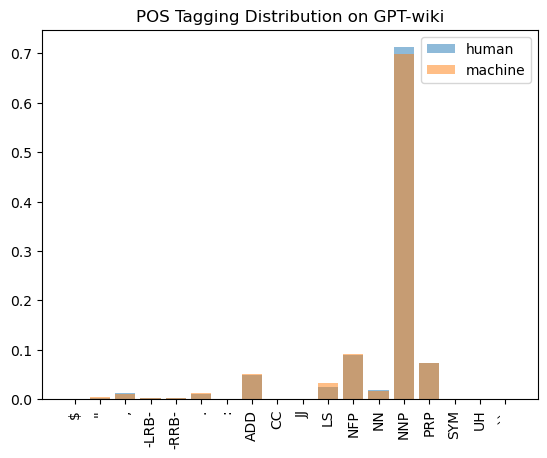

In [31]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos')
human_text, machine_text = fetch_text(train_df.sample(300))

human_dict = pipe_add(pos_func, human_text, nlp)
machine_dict = pipe_add(pos_func, machine_text, nlp)

human_norm_dict, machine_norm_dict = norm_func(human_dict, machine_dict)
draw_func(human_norm_dict, machine_norm_dict, dataset_name, "xpos")

### Dependency Parsing

In [25]:
def deprel_func(sentences, nlp):
    doc = nlp(sentences)
    deprel_dist = defaultdict(int)
    for sent in doc.sentences:
        for word in sent.words:
            deprel_dist[word.deprel] += 1
    return deprel_dist

2023-04-18 19:26:10 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-04-18 19:26:10 WARNING: Can not find mwt: default from official model list. Ignoring it.
2023-04-18 19:26:10 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |
| depparse  | combined |

2023-04-18 19:26:10 INFO: Using device: cuda
2023-04-18 19:26:10 INFO: Loading: tokenize
2023-04-18 19:26:10 INFO: Loading: pos
2023-04-18 19:26:11 INFO: Loading: lemma
2023-04-18 19:26:11 INFO: Loading: depparse
2023-04-18 19:26:11 INFO: Done loading processors!
100%|██████████| 4976/4976 [09:05<00:00,  9.12it/s]


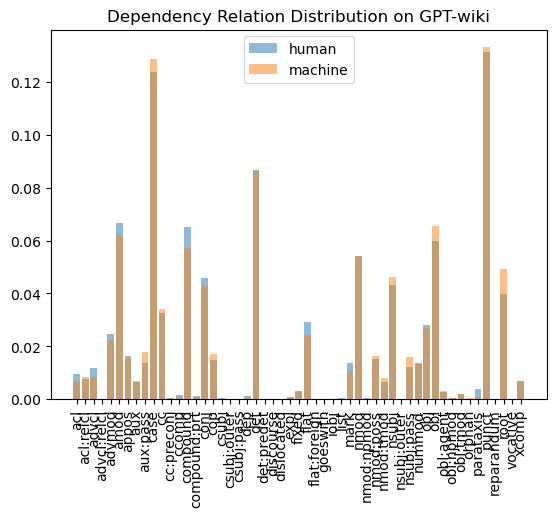

In [29]:
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma,depparse')
human_text, machine_text = fetch_text(train_df.sample(10000))

human_dict = pipe_add(deprel_func, human_text, nlp)
machine_dict = pipe_add(deprel_func, machine_text, nlp)

human_norm_dict, machine_norm_dict = norm_func(human_dict, machine_dict)
draw_func(human_norm_dict, machine_norm_dict, dataset_name, "deprel")